# Predicting Fuel Efficiency Based On Car Features


>###### *Which features are most predictive of a gas guzzler?*
>**Overview**: The data come from Seaborn's "mpg". In this project, I built predictive models which can be used to predict fuel efficiency of vehicles from various features. The project involved extensive Exploratory Data Analysis (EDA), visualizations, feature selection and transformation, hyperparameter tuning, and the application of several machine learning models including Linear Regression, Decision Tree Regression, and Random Forest Regression. In the end, I was able to achieve fairly respectable predictive results while managing model variance (and complexity).


------

In [ ]:
#Here I import relevant packages
!pip install fuzzywuzzy
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
#The data file for this project is available from the Seaborn website
data = sns.load_dataset('mpg')

##EDA

In [ ]:
data.head().T

,0,1,2,3,4
mpg,18.0,15.0,18.0,16.0,17.0
cylinders,8,8,8,8,8
displacement,307.0,350.0,318.0,304.0,302.0
horsepower,130.0,165.0,150.0,150.0,140.0
weight,3504,3693,3436,3433,3449
acceleration,12.0,11.5,11.0,12.0,10.5
model_year,70,70,70,70,70
origin,usa,usa,usa,usa,usa
name,chevrolet chevelle malibu,buick skylark 320,plymouth satellite,amc rebel sst,ford torino


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [ ]:
#Let's check out the data with null 'horsepower' values
data[data.horsepower.isnull()].T

,32,126,330,336,354,374
mpg,25.0,21.0,40.9,23.6,34.5,23.0
cylinders,4,6,4,4,4,4
displacement,98.0,200.0,85.0,140.0,100.0,151.0
horsepower,NaN,NaN,NaN,NaN,NaN,NaN
weight,2046,2875,1835,2905,2320,3035
acceleration,19.0,17.0,17.3,14.3,15.8,20.5
model_year,71,74,80,80,81,82
origin,usa,usa,europe,usa,europe,usa
name,ford pinto,ford maverick,renault lecar deluxe,ford mustang cobra,renault 18i,amc concord dl


In [ ]:
#Creating a 'brand' fea|ture so I can clean and then impute these missing horsepower data
data['brand'] = data['name'].apply(lambda x: x.split(' ')[0])

In [ ]:
#Unique Brands and Origins - mainly I'm checking for misspellings in the categorical variables.
ubrands = list(set(data['brand']))
ubrands.sort()
uorigins = list(set(data['origin']))
uorigins.sort()
print(f'All the brands: {ubrands}\n\nAll the countries: {uorigins}')

All the brands: ['amc', 'audi', 'bmw', 'buick', 'cadillac', 'capri', 'chevroelt', 'chevrolet', 'chevy', 'chrysler', 'datsun', 'dodge', 'fiat', 'ford', 'hi', 'honda', 'maxda', 'mazda', 'mercedes', 'mercedes-benz', 'mercury', 'nissan', 'oldsmobile', 'opel', 'peugeot', 'plymouth', 'pontiac', 'renault', 'saab', 'subaru', 'toyota', 'toyouta', 'triumph', 'vokswagen', 'volkswagen', 'volvo', 'vw']

All the countries: ['europe', 'japan', 'usa']


In [ ]:
#Clearly there are some spelling errors to correct with the following brands (i.e. Toyota spelled as Toyouta)
correct_brands = ['toyota', 'chevrolet', 'volkswagen', 'ihc', 'mazda', 'mercedes-benz']

#From fuzzywuzzy, extractOne returns the best match for each of the possibly misspelled makes by matching the correct_brands list. The value is a similarity metric (80).
def correct_brand(brand):
  match = process.extractOne(brand, correct_brands)
  if match[1] >= 80:
    return match[0]
  #Otherwise, return the original brand
  return brand

data['brand'] = data['brand'].apply(correct_brand)
data.drop(columns=['name'], inplace=True)

In [ ]:
#imputing N/A horsepower data by using average horsepower of those cars with the same brand and cylinder count
data['imputed_horsepower'] = data.groupby(['brand','cylinders'])['horsepower'].transform(lambda x: x.mean())
data['horsepower'] = data['horsepower'].fillna(data['imputed_horsepower'])
data = data.drop('imputed_horsepower', axis = 1)

##A bit of basic visualization

In [ ]:
brand_counts = data['brand'].value_counts()
percentages = brand_counts / brand_counts.sum()

threshold = 0.02

labels = []
for brand, percentage in zip(brand_counts.index, percentages):
    if percentage > threshold:
        labels.append(brand)
    else:
        labels.append('')

brand_counts

ford             51
chevrolet        44
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
buick            17
pontiac          16
volkswagen       16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
vw                6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
chevy             3
mercedes-benz     3
cadillac          2
bmw               2
capri             1
hi                1
triumph           1
nissan            1
Name: brand, dtype: int64

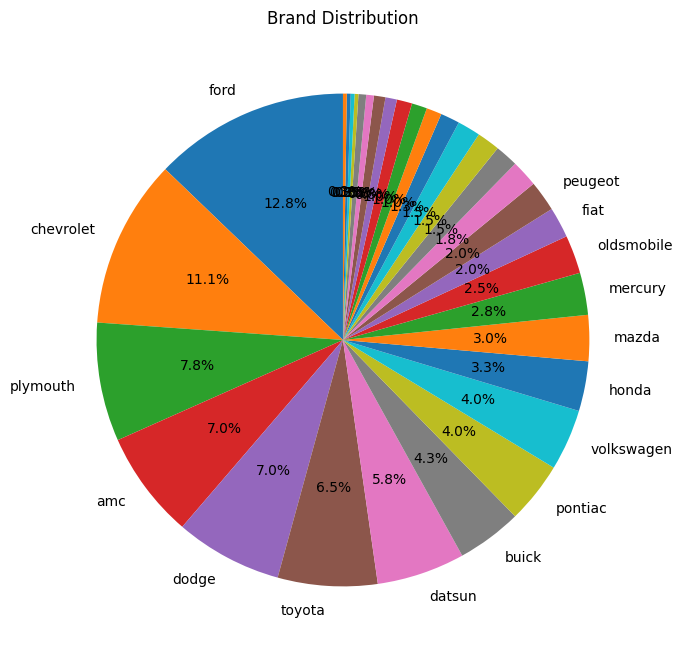

In [ ]:
plt.figure(figsize=(10, 8))
plt.pie(brand_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Brand Distribution')
plt.show()

<ipython-input-341-57f276c319b6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['mpg'])


<Axes: xlabel='mpg', ylabel='Density'>

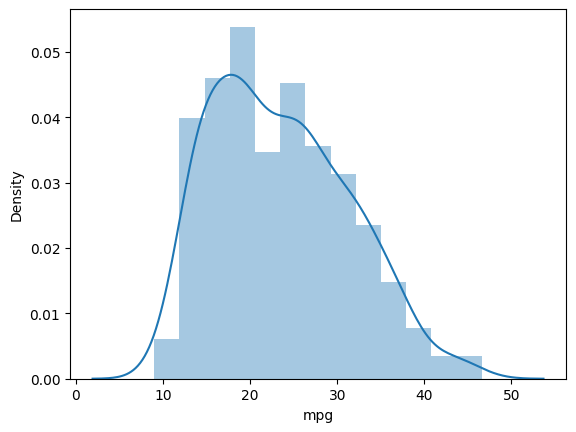

In [ ]:
#See the distribution of mpg is relatively normally distributed
sns.distplot(data['mpg'])

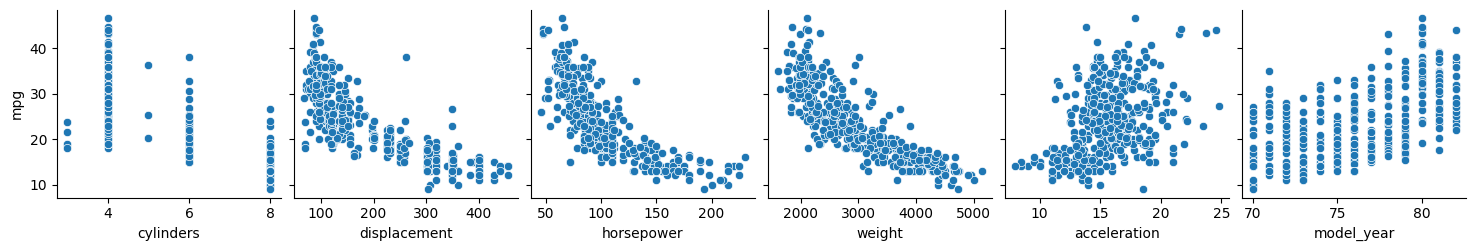

In [ ]:
#now, a look against each of the independent variables. Slight visible trend for each variable, seems non-linear for some.
sns.pairplot(data, y_vars = ['mpg'], x_vars = ['cylinders','displacement','horsepower','weight','acceleration','model_year'])


In [ ]:
#The predictors don't look linearly related to the response variable at all. Let's transform them so they look better

data['displacement'] = (data['displacement'])**(1/2)
data['horsepower'] = 1/(data['horsepower'])
data['weight'] = (1/(data['weight']))**(1/2)
data['acceleration'] = (data['acceleration'])
data['mpg_log'] = np.log(data['mpg'])

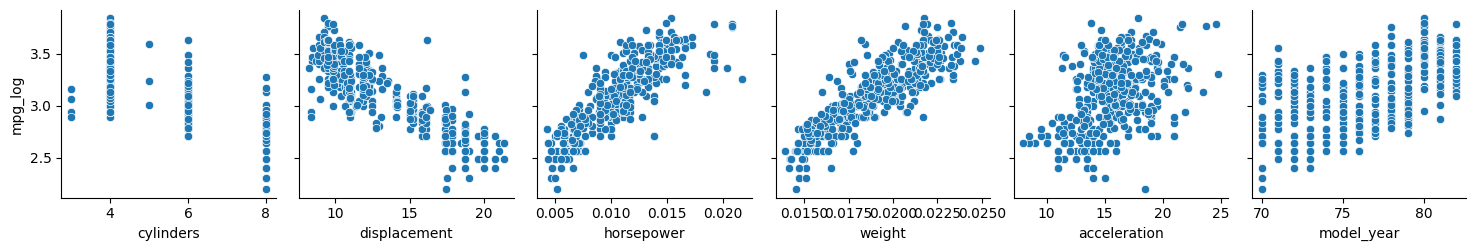

In [ ]:
#Much better. Acceleration feature is still questionable
sns.pairplot(data, y_vars = ['mpg_log'], x_vars = ['cylinders','displacement','horsepower','weight','acceleration','model_year'])

In [ ]:
#Rescaling the data in the numeric columns
scaler = StandardScaler()
cols = ['cylinders','displacement','horsepower','weight','acceleration','model_year']
data[cols] = scaler.fit_transform(data[cols])

<ipython-input-346-e997b1e66ef3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<Axes: >

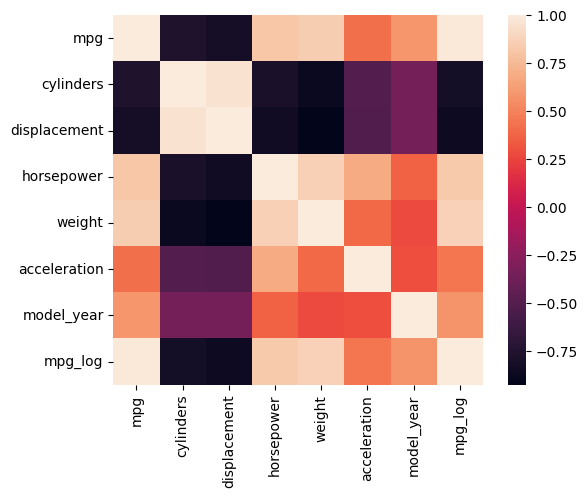

In [ ]:
#Correlation data
corr = data.corr()
sns.heatmap(corr, square = True)

In [ ]:
#Easier to see magnitude of correlation data vs target variable using this method
corr_sorted=data.corr()[['mpg_log']].abs().sort_values(by = 'mpg_log', ascending = False)
corr_sorted

<ipython-input-347-efe8d7ec8553>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_sorted=data.corr()[['mpg_log']].abs().sort_values(by = 'mpg_log', ascending = False)


,mpg_log
mpg_log,1.000000
mpg,0.983776
weight,0.867993
displacement,0.862041
horsepower,0.828289
cylinders,0.825758
model_year,0.576342
acceleration,0.445809


#####**I will need to remember to back-transform the predictions because I transformed y = log(y)**

In [ ]:
#Storing remaining categorical variables as dummies
categorical_dummies = pd.get_dummies(data[['origin','brand']])
data = data.join(categorical_dummies)
data.drop(columns = ['origin','brand'], inplace = True)

In [ ]:
#This could've been sorted with visualizations, but also good to see
final_corr = data.corr()[['mpg_log']].abs().sort_values(by = 'mpg_log', ascending = False)
final_corr[:15]

,mpg_log
mpg_log,1.000000
mpg,0.983776
weight,0.867993
displacement,0.862041
horsepower,0.828289
cylinders,0.825758
model_year,0.576342
origin_usa,0.568766
acceleration,0.445809
origin_japan,0.431193


In [ ]:
#Split the data into test and training datasets
target = data['mpg_log']
predictors = data.drop(columns = ['mpg', 'mpg_log'])
X_train, X_test, y_train, y_test = tts(predictors,target, test_size = 0.2, random_state = 0)

##Linear Regression

In [ ]:
#Here we perform Linear regression and determine the different train/test accuracies depending on number of variables used

#R-squared scores
trainScoresR2 = []
testScoresR2 = []
#MSE scores
trainScoresMSE = []
testScoresMSE = []
trainScoresMSE_orig = []
testScoresMSE_orig = []

model = LinearRegression()

for i in range(1, len(X_train.columns) + 1):
    #iteratively selects the k best features from 1 to all of the features
    fs = SelectKBest(score_func=mutual_info_regression, k=i)
    fs.fit(X_train, y_train)

    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)

    model.fit(X_train_fs, y_train)

    train_pred = model.predict(X_train_fs)
    test_pred = model.predict(X_test_fs)

    #Reverse the log transformation, since the target variable was transformed to from y to log(y)
    train_pred_orig = np.exp(train_pred)
    test_pred_orig = np.exp(test_pred)
    y_train_orig = np.exp(y_train)
    y_test_orig = np.exp(y_test)

    #compute some metrics

    #R-squared score with transformed predictions
    trainScoreR2 = r2_score(y_train, train_pred)
    testScoreR2 = r2_score(y_test, test_pred)
    #MSE with transformed predictions
    trainScoreMSE = mean_squared_error(y_train, train_pred)
    testScoreMSE = mean_squared_error(y_test, test_pred)
    #MSE with reverse-transformed predictions
    trainScoreMSE_orig = mean_squared_error(y_train_orig, train_pred_orig)
    testScoreMSE_orig = mean_squared_error(y_test_orig, test_pred_orig)

    #Append scores to lists
    trainScoresR2.append(trainScoreR2)
    testScoresR2.append(testScoreR2)
    trainScoresMSE.append(trainScoreMSE)
    testScoresMSE.append(testScoreMSE)
    trainScoresMSE_orig.append(trainScoreMSE_orig)
    testScoresMSE_orig.append(testScoreMSE_orig)

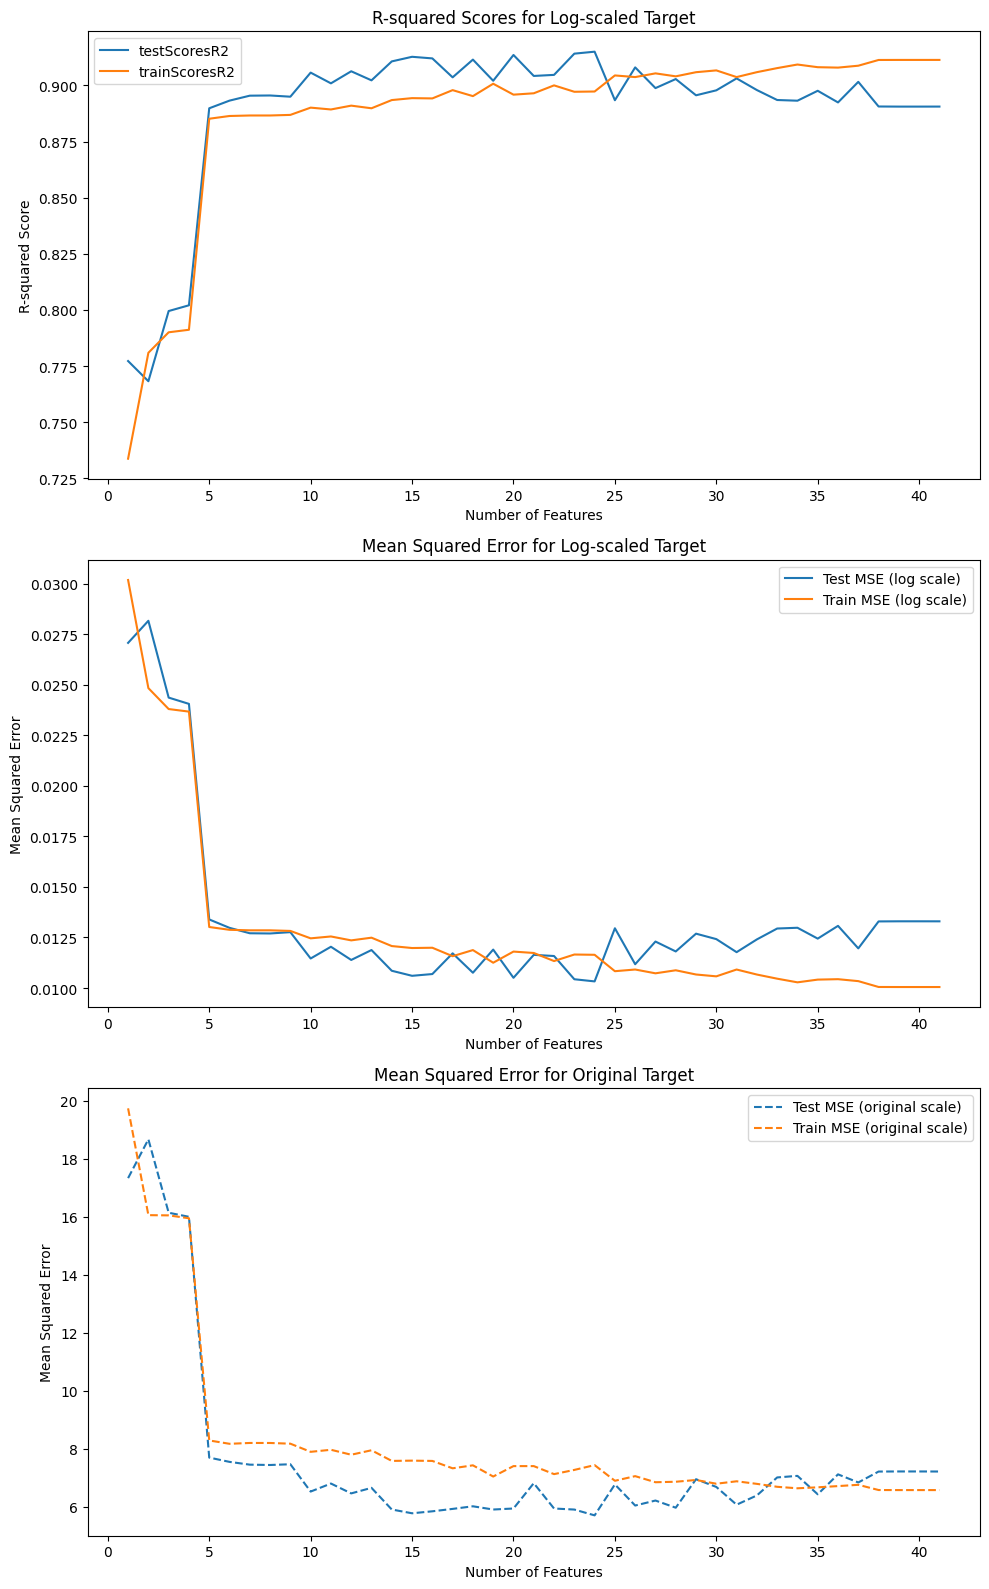

In [ ]:
#Here we find the model with the ideal number of features
#balancing bias with variance by seeking the smallest number of features that come close to the peak predictive accuracy

counter = [i for i in range(1,len(X_train.columns)+1)]

#create a dataframe to store the data
finaldf = pd.DataFrame(data = {'numFeatures': counter,
                               'testScoresR2': testScoresR2,
                               'trainScoresR2': trainScoresR2,
                               'testScoresMSE': testScoresMSE,
                               'trainScoresMSE': trainScoresMSE,
                               'testScoresMSE_orig': testScoresMSE_orig,
                               'trainScoresMSE_orig': trainScoresMSE_orig})

fig, ax = plt.subplots(3, 1, figsize=(10, 16))

#R2 scores
finaldf.plot('numFeatures', ['testScoresR2','trainScoresR2'], ax=ax[0])
ax[0].set_title('R-squared Scores for Log-scaled Target')
ax[0].set_xlabel('Number of Features')
ax[0].set_ylabel('R-squared Score')
#MSE scores for log-scaled target
finaldf.plot('numFeatures', ['testScoresMSE','trainScoresMSE'], ax=ax[1], label=['Test MSE (log scale)', 'Train MSE (log scale)'])
ax[1].set_title('Mean Squared Error for Log-scaled Target')
ax[1].set_xlabel('Number of Features')
ax[1].set_ylabel('Mean Squared Error')
#MSE scores for original target
finaldf.plot('numFeatures', ['testScoresMSE_orig','trainScoresMSE_orig'], ax=ax[2], linestyle='--', label=['Test MSE (original scale)', 'Train MSE (original scale)'])
ax[2].set_title('Mean Squared Error for Original Target')
ax[2].set_xlabel('Number of Features')
ax[2].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()

In [ ]:
#choosing the lowest amount of variables with a score within 1 standard deviation of the max score
testScores_stdR2 = np.std(testScoresR2)
testScores_maxR2 = np.max(testScoresR2)
optimal_num_featuresR2 = np.where(testScoresR2 >= testScores_maxR2 - testScores_stdR2)[0][0] + 1
#similar but minimizing MSE without growing the model too large
testScores_stdMSE = np.std(testScoresMSE)
testScores_minMSE = np.min(testScoresMSE)
optimal_num_featuresMSE = np.where(testScoresMSE <= testScores_minMSE + testScores_stdMSE)[0][0] + 1
#on the untransformed data
testScores_stdMSE_orig = np.std(testScoresMSE_orig)
testScores_minMSE_orig = np.min(testScoresMSE_orig)
optimal_num_featuresMSE_orig = np.where(testScoresMSE_orig <= testScores_minMSE_orig + testScores_stdMSE_orig)[0][0] + 1

In [ ]:
#prefer f string but this seemed more readable this time
print("R2 in Log Space, with {} features:\nTrain: {}\nTest: {}\n\n".format(optimal_num_featuresR2, trainScoresR2[optimal_num_featuresR2-1], testScoresR2[optimal_num_featuresR2-1]))
print("MSE in Log Space, with {} features:\nTrain: {}\nTest: {}\n\n".format(optimal_num_featuresMSE, trainScoresMSE[optimal_num_featuresMSE-1], testScoresMSE[optimal_num_featuresMSE-1]))
print("MSE in Reverse-Transformed (original) Space, with {} features:\nTrain: {}\nTest: {}\n\n".format(optimal_num_featuresMSE_orig, trainScoresMSE_orig[optimal_num_featuresMSE_orig-1], testScoresMSE_orig[optimal_num_featuresMSE_orig-1]))


R2 in Log Space, with 5 features:
Train: 0.8851809304668641
Test: 0.8898342067324235


MSE in Log Space, with 5 features:
Train: 0.013018847534376285
Test: 0.013392290320675094


MSE in Reverse-Transformed (original) Space, with 5 features:
Train: 8.28006821060219
Test: 7.688627683085104




#Tree Models

In [ ]:
#going to use this to get the R^2 scores on the training data and testing data
def tree_scoring(y_test, y_pred):
  trainR2 = r2_score(y_train, train_pred)
  testR2 = r2_score(y_test,y_pred)

  print('Train R^2: ',trainR2,'\nTest R^2:', testR2)

##Decision Tree Regression

This may not provide a huge boost in predictive power because decision trees are not additive models. In other words, because the predictors do seem to be linearly correlated to the response variable, a decision tree may have to build a complex model to achieve similar bias. On the other hand, it may have higher variance that is inherent with this model. For this reason, if anything, I expect the random forest to perform better when generalizing. And on the other hand, I think a gradient boosted model may do the best when it comes to improving the bias by "chasing" the data with poor predictions in previous stumps.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint

#I'm going to search this parameter grid
param_grid = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 50)
}

dt = DecisionTreeRegressor()

#Randomized search CV with 10-fold cross validation
dt_random = RandomizedSearchCV(estimator = dt,
                               param_distributions = param_grid,
                               n_iter = 100,
                               cv = 10,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

#fit
dt_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec6a41f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec6e2260>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec6e2680>},
                   random_state=42, verbose=2)

In [ ]:
#The best parameters
print("Best Parameters for DecisionTreeRegressor: ", dt_random.best_params_)

#Here, I train a new model with the best parameters which we found from crossvalidation.
best_dt = DecisionTreeRegressor(max_depth=dt_random.best_params_['max_depth'],
                                min_samples_split=dt_random.best_params_['min_samples_split'],
                                min_samples_leaf=dt_random.best_params_['min_samples_leaf'])

#fit
best_dt.fit(X_train, y_train)

#making predictions
best_dt_pred = best_dt.predict(X_test)

#using my predefined function to score
tree_scoring(y_test, best_dt_pred)

Best Parameters for DecisionTreeRegressor:  {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 9}
Train R^2:  0.9113803920491852 
Test R^2: 0.892353536225046


#Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#Again, I'm going to search this parameter grid
param_grid = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 50),
    'min_samples_leaf': randint(1, 50)
}

rf = RandomForestRegressor()

#Again, 10-fold cross validation while randomly searching the grid for hyperparameters
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = param_grid,
                               n_iter = 100,
                               cv = 10,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

#fit
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec70f7f0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec5bf490>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec70d090>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7c0aec70f460>},
                   random_state=42, verbose=2)

In [ ]:
print("Best Parameters for RF: ", rf_random.best_params_)

#The best parameters
best_rf = RandomForestRegressor(max_depth=rf_random.best_params_['max_depth'],
                                min_samples_split=rf_random.best_params_['min_samples_split'],
                                min_samples_leaf=rf_random.best_params_['min_samples_leaf'])
#fit
best_rf.fit(X_train, y_train)
#making predictions with the model
best_rf_pred = best_rf.predict(X_test)
#using my predefined function to score
tree_scoring(y_test, best_rf_pred)

Best Parameters for RF:  {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 22, 'n_estimators': 170}
Train R^2:  0.9113803920491852 
Test R^2: 0.8999698074691317
